# Consumption and Segregation in Chicago Communities

### Introduction

#### Backgroud
Segregation has always been a critical issue for Chicago. While the city’s overall population is fairly evenly divided -- approximately 32 percent white, 30 percent black, and 29 percent Hispanic, according to a report on CBS, these people are segmented into 77 different communities, living starkly different lives -- and there are striking patterns involving who lives in which neighborhood, and why.    

[“The place that you live shapes so profoundly all aspects of your life,”](https://chicago.cbslocal.com/2019/02/11/race-segregation-chicago-neighborhoods/) said Maria Krysan, professor of sociology at the University of Illinois at Chicago. Indeed, Chicago citizens with different racial or economic backgrounds not only dwell in divergent residential environments but are also exposed to extremely different public spaces and resources, which in turn shapes their ways of living. This project looks into one specific aspect of the life of Chicago residents -- their consumption options in their respective living spaces.   

#### Question
Consumption works as a way through which social belonging and distinction are built and expressed, and these destinations, targeting specific users, include some while excluding others (Bolzoni 2016). It is reasonable to assume that segregation in Chicago city can be reflected in people’s daily consumption -- in other words, their options on where to spend money on food, retail goods, activities, etc. This project aims to verify this assumption. __Apart from residential segregation, are citizens with different social backgrounds exposed to different access to public consumption spaces?__    

The project does not assume or attempts to deduct a causal relationship between segregation and access to consumption options, but simply tries to show that some correlation exists in between the two. 

#### Data Acquisition
The first step of this project is to cluster the 77 Chicago community areas based on the top 10 most commonly occurred venue types in each area. I used **Four Square Location Data** for this part. The second step is to closely examine the characteristics of residents in each community, and to see if communities with similar residents are put into the same cluster in the previous step. I extracted data from two sources, including __[Chicago 2017 Census data](https://www.kaggle.com/apgross/chicagocensusdata#censusData.csv) and [Chicago Community Snapshots](https://www.cmap.illinois.gov/data/community-snapshots)__. 

#### Method
In the second step, a classification model will be developed in which cluster labels generated in step 1 will be treated as a response variable, while resident features in each community, such as *median per capita income*, _race composition_, *age composition*, etc., will serve as independent variables. The model will be used to test correlations between resident features and the cluster labels ---- if correlation is strong, the model will yield a higher accuracy rate when estimating the cluster labels using resident features. 

#### Interests
This can be a preliminary step in further studies of socioeconomic segregation in the U.S. urban areas. Previous studies are mostly focused on the residential distribution of the urban population, while this project aims to find patterns of spatial segregation that are related to the use and accessibility of public consumption spaces. The result of this study can be of interests to scholars, policymakers, social workers and/or activists, as well as those who are directly affected by such segregation. 

In [1]:
# Install and import all necessary stuff
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
import bs4
from bs4 import BeautifulSoup

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

# KMeans clustering packages
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker

# Seaborn
import seaborn as sns

print('Folium installed')
print('Libraries imported.')

Folium installed
Libraries imported.


## 1. Venue Data Acquirement and Wrangling

First, we get the name and coordinates of the 77 chicago communities. 

In [2]:
chi_df = pd.read_csv('censusData.csv')
chi_df.columns = chi_df.columns.str.replace(' ', '_')
chi_df.columns = [x.lower() for x in chi_df.columns]
chi_df.head()

# Make minor change in community names, change wrong spellings
chi_df["community_area_name"] = chi_df["community_area_name"].apply(lambda x: "{}, {}, {}".format(x, "Chicago", "IL"))
chi_df.community_area_name[chi_df.community_area_name == 'Montclaire, Chicago, IL'] = 'Montclare, Chicago, IL'
chi_df.community_area_name[chi_df.community_area_name == 'Washington Height, Chicago, IL'] = 'Washington Heights, Chicago, IL'

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [3]:
# Define a function that gets the coordinates of a list of places 
def getCoords(names):
    coords = []
    for name in names:
        address = name
        geolocator = Nominatim(user_agent = "chi_explorer")
        try:
            location = geolocator.geocode(address)
            latitude = location.latitude
            longitude = location.longitude
            str = [latitude, longitude]
            coords.append(str)
            
        except: 
            str = 'N/A'
            coords.append([str])
            print(name + " can't be processed")
            
    return coords

In [4]:
#coordinates = getCoords(chi_df['community_area_name'])
#coordinates = pd.DataFrame(coordinates)
#chi_df = pd.concat([chi_df, coordinates], axis = 1)
#chi_df = chi_df[['community_area_name', 0, 1]]
#chi_df.rename(columns = {0 : "Latitude", 1 : "Longitude"}, inplace = True)

#chi_df.Latitude[chi_df.community_area_name == 'Grand Boulevard, Chicago, IL'] = 41.8131
#chi_df.Longitude[chi_df.community_area_name == 'Grand Boulevard, Chicago, IL'] = -87.6178
#chi_df.Latitude[chi_df.community_area_name == 'Lincoln Square, Chicago, IL'] = 41.9687
#chi_df.Longitude[chi_df.community_area_name == 'Lincoln Square, Chicago, IL'] = -87.6890

# I saved the resulting dataset so I wouldn't have to run the search again every time
#pd.DataFrame.to_csv(chi_df, "chicago_community_coords.csv")

In [5]:
# I'm reading in the saved dataset. 
chi_df = pd.read_csv("chicago_community_coords.csv")
chi_df = chi_df.drop('Unnamed: 0', axis = 1)

Draw a map to see if the communitiy coordinates are correctly obtained

In [6]:
# Get the coordinats of Chicago
address = 'Chicago, IL'
geolocator = Nominatim(user_agent = "chi_explorer")
location = geolocator.geocode(address)
chi_lat = location.latitude
chi_lng = location.longitude
print(chi_lat, chi_lng)

41.8755616 -87.6244212


In [7]:
# Create map of Chicago using latitude and longitude values
map_chicago = folium.Map(location = [chi_lat, chi_lng], zoom_start = 10)

# Add markers to the map
for lat, lng, comm in zip(chi_df['Latitude'], chi_df['Longitude'], chi_df['community_area_name']):
    label = comm
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 4,
        popup = label,
        color = 'darkblue',
        fill = True,
        fill_color = '#ffffff',
        parse_html = False).add_to(map_chicago)  
    
map_chicago

## 2. K-Means Clustering Communities by Venues

Next, we use the FourSquare API to search for venues around the coordinates we obtained.

In [8]:
# Set up Four Square credentials 
CLIENT_ID = 'DU1RZNIYZKMR4ND3KK4F3FASRDB1GJGKM0TYVLLLF0NFQKZU' # Foursquare ID
CLIENT_SECRET = '30BO30FW3YDGZM0BQO0VV0VR0WDPNYESACKI4UFCQD1IAPX4' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
CLIENT_ID: DU1RZNIYZKMR4ND3KK4F3FASRDB1GJGKM0TYVLLLF0NFQKZU
CLIENT_SECRET:30BO30FW3YDGZM0BQO0VV0VR0WDPNYESACKI4UFCQD1IAPX4


In [9]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

It is hard to determine the radius for searching. Some of

In [10]:
def getNearbyVenues(names, latitudes, longitudes):
    radius = 2000
    LIMIT = 100
    urlformat = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'
    
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = urlformat.format(CLIENT_ID, 
                               CLIENT_SECRET, 
                               VERSION, 
                               lat, 
                               lng, 
                               radius, 
                               LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Community', 
                  'Community Latitude', 
                  'Community Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [11]:
#chicago_venues = getNearbyVenues(names = chi_df['community_area_name'],
#                                 latitudes = chi_df['Latitude'],
#                                 longitudes = chi_df['Longitude']
#                                )

Again, I saved the result so I won't have to run the above codes over and over again. 

In [12]:
#pd.DataFrame.to_csv(chicago_venues, "chicago_venues.csv")
chicago_venues = pd.read_csv("chicago_venues.csv")
chicago_venues = chicago_venues.drop('Unnamed: 0', axis = 1)
chicago_venues.head()

,Community,Community Latitude,Community Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rogers Park, Chicago, IL",42.010531,-87.670748,Morse Fresh Market,42.008087,-87.667041,Grocery Store
1,"Rogers Park, Chicago, IL",42.010531,-87.670748,El Famous Burrito,42.010421,-87.674204,Mexican Restaurant
2,"Rogers Park, Chicago, IL",42.010531,-87.670748,Rogers Park Social,42.007360,-87.666265,Bar
3,"Rogers Park, Chicago, IL",42.010531,-87.670748,Bark Place,42.010080,-87.675223,Pet Store
4,"Rogers Park, Chicago, IL",42.010531,-87.670748,Glenwood Sunday Market,42.008525,-87.666251,Farmers Market


Check how many venues are returned for each community. 

In [13]:
# Count number of venues in each neighborhood, sort the result ascendingly. 
num = pd.DataFrame(chicago_venues.groupby('Community').count()['Venue Category']).sort_values(by = 'Venue Category').reset_index()

Calculate the frequency of venue occurances for every community, generate a dataframe. 

In [14]:
# One hot encoding
chicago_onehot = pd.get_dummies(chicago_venues['Venue Category'], prefix="", prefix_sep="")

# Move neighborhood column to the first column
fixed_columns = [chicago_onehot.columns[-1]] + list(chicago_onehot.columns[:-1])
chicago_onehot = chicago_onehot[fixed_columns]
chicago_onehot = chicago_onehot.drop('Neighborhood', axis=1)  

In [15]:
# Put Neighbourhood names back to the one-hot-coded dataframe
names = pd.DataFrame(chicago_venues['Community'])
chicago = pd.concat([names, chicago_onehot], axis=1)

# Get the frenquency of occurances of each type of venue for each neighborhood
chicago = chicago.groupby('Community').mean().reset_index()
chicago.head()

,Community,Yoga Studio,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,...,Vietnamese Restaurant,Warehouse,Warehouse Store,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,"Albany Park, Chicago, IL",0.01,0.0,0.0,0.01,0.00,0.0,0.0,0.0,0.0,...,0.02,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.01,0.0
1,"Archer Heights, Chicago, IL",0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.01,0.0
2,"Armour Square, Chicago, IL",0.00,0.0,0.0,0.00,0.01,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.01,0.0
3,"Ashburn, Chicago, IL",0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.013158,0.0,0.0,0.0,0.00,0.0
4,"Auburn Gresham, Chicago, IL",0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0


Get the top 10 venues for each community. 

In [16]:
# Define a function that returns the most common venue of a community
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [17]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# Create columns according to number of top venues
columns = ['Community']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Create a new dataframe
chicago_venues_sorted = pd.DataFrame(columns = columns)
chicago_venues_sorted['Community'] = chicago['Community']

for ind in np.arange(chicago.shape[0]):
    chicago_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chicago.iloc[ind, :], num_top_venues)

chicago_venues_sorted.head()

,Community,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Albany Park, Chicago, IL",Korean Restaurant,Park,Coffee Shop,Pizza Place,Chinese Restaurant,Grocery Store,Sandwich Place,Asian Restaurant,Supermarket,Mexican Restaurant
1,"Archer Heights, Chicago, IL",Mexican Restaurant,Discount Store,Mobile Phone Shop,Donut Shop,Sandwich Place,Grocery Store,Pizza Place,Bank,Video Store,Fast Food Restaurant
2,"Armour Square, Chicago, IL",Chinese Restaurant,Pizza Place,Mexican Restaurant,Bar,Korean Restaurant,Hot Dog Joint,Asian Restaurant,Coffee Shop,Italian Restaurant,Dessert Shop
3,"Ashburn, Chicago, IL",Park,Pizza Place,Convenience Store,Liquor Store,Ice Cream Shop,Sandwich Place,Fast Food Restaurant,Donut Shop,Mexican Restaurant,Coffee Shop
4,"Auburn Gresham, Chicago, IL",Fast Food Restaurant,Discount Store,Intersection,Fried Chicken Joint,Grocery Store,Pharmacy,Sandwich Place,American Restaurant,Chinese Restaurant,Cosmetics Shop


Cluster the communities using the data we calculated in the previous steps. in this step, we first try to find the optimal number of clusters for this dataset. In the following loop, number 3~10 are tested as the number of clusters, and the corresponding performance plots are generated. 

In [18]:
chicago_clustering = chicago.drop('Community', axis = 1)

scores = pd.DataFrame(columns = ['k', 'sse', 'silhouette_coeff'])

# Compare three methods to determine the best k
for k in range(3, 10):
    
    kmeans = KMeans(n_clusters = k, random_state = 0).fit(chicago_clustering)
    labels = kmeans.labels_
    
    # Get the scores
    sse = kmeans.inertia_
    sil_coeff = silhouette_score(chicago_clustering, labels, metric='euclidean')
    score = [k, sse, sil_coeff]
    scores.loc[len(scores), :] = score

In [19]:
scores['sse'] = scores.sse.astype('float') # Elbow Criterion
scores['silhouette_coeff'] = scores.silhouette_coeff.astype('float') # Silhouette Coefficient

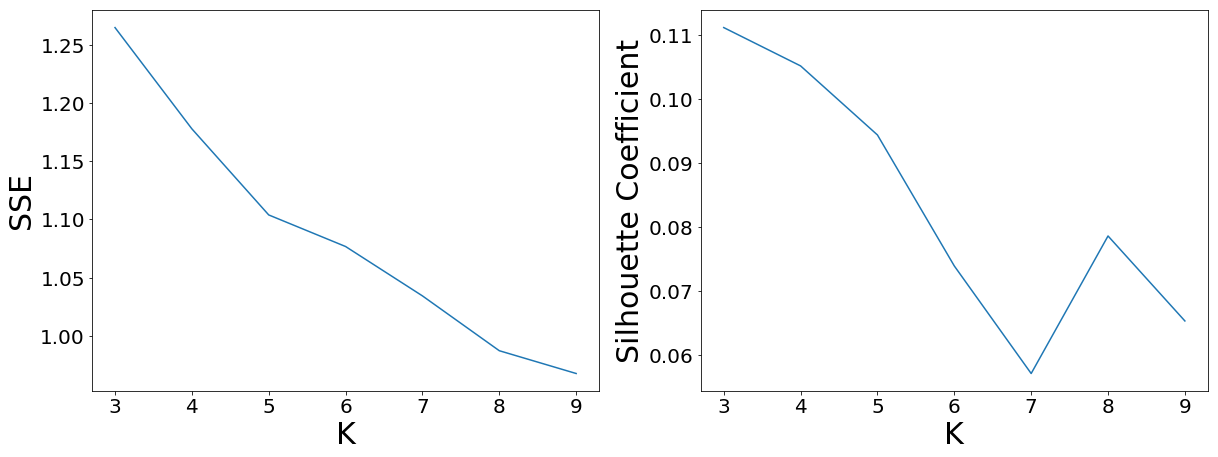

In [20]:
f, axes = plt.subplots(1, 2, figsize=(20,7))

sns.lineplot(x = 'k', y = 'sse', data = scores, ax = axes[0])
axes[0].set_xlabel('K',fontsize=30);
axes[0].set_ylabel('SSE',fontsize=30);
axes[0].tick_params(axis = 'both', which = 'major', labelsize = 20)

sns.lineplot(x = 'k', y = 'silhouette_coeff', data = scores, ax = axes[1])
axes[1].set_xlabel('K',fontsize=30);
axes[1].set_ylabel('Silhouette Coefficient',fontsize=30);
axes[1].tick_params(axis = 'both', which = 'major', labelsize = 20)

plt.savefig('2.3.png')

Apparently, 5 is the optimal k. Now that we have found the best K, let's set up our model. 

In [21]:
# Set number of clusters
kclusters = 5

# Run k-means clustering
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(chicago_clustering)

# Check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 2, 1, 1, 0, 0, 0, 3, 2, 0], dtype=int32)

In [22]:
# Add clustering labels
chicago_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
chicago_venues_sorted.head()

# Merge toronto_grouped with chicago data to add latitude/longitude for each community
chi_df.rename(columns = {'community_area_name':'Community'}, inplace = True)
chicago_merged = chi_df
chicago_merged = chicago_merged.join(chicago_venues_sorted.set_index('Community'), on = 'Community').dropna(axis = 0)
# For some reason the labels changed to floats after the join. Quick fix!
chicago_merged['Cluster Labels'] = chicago_merged['Cluster Labels'].astype(int)
chicago_merged.head()

,Community,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Rogers Park, Chicago, IL",42.010531,-87.670748,1,Beach,Park,Pizza Place,Café,Coffee Shop,Diner,Bar,Gym,Bakery,Mexican Restaurant
1,"West Ridge, Chicago, IL",42.003548,-87.696243,1,Indian Restaurant,Grocery Store,Mexican Restaurant,Coffee Shop,Pizza Place,Pakistani Restaurant,Pharmacy,Korean Restaurant,Gym,Burger Joint
2,"Uptown, Chicago, IL",41.966630,-87.655546,3,Vietnamese Restaurant,Coffee Shop,Sushi Restaurant,Hot Dog Joint,Breakfast Spot,Pizza Place,Park,Grocery Store,Bakery,Vegetarian / Vegan Restaurant
3,"Lincoln Square, Chicago, IL",41.968700,-87.689000,1,Bar,Thai Restaurant,Brewery,Pizza Place,Park,Gym,Coffee Shop,New American Restaurant,Italian Restaurant,Gourmet Shop
4,"North Center, Chicago, IL",41.956107,-87.679160,1,Pizza Place,Bar,Salon / Barbershop,Gym,Brewery,Breakfast Spot,Italian Restaurant,Gourmet Shop,Coffee Shop,Yoga Studio


Let's visualize the clusters on the map. 

In [23]:
# Create map
map_clusters = folium.Map(location=[chi_lat, chi_lng], zoom_start=10)

# Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chicago_merged['Latitude'], chicago_merged['Longitude'], chicago_merged['Community'], chicago_merged['Cluster Labels']):
    label = folium.Popup(poi + ", cluster: " + str(cluster), parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters.save("2.4.html")
map_clusters

## 3. Exploratory Analysis ----     
### What are the venues and residents like in each community cluster? 

First, we have a look at the most common venues in each cluster. 

In [50]:
# Define a function that returns the top 10 most common venue types in a cluster
def get_common_venues_in_cluster(cluster):
    df = pd.DataFrame(columns = ['index'])# set up an empty dataframe
    for col in cluster.columns[1:]:
        df.t = pd.DataFrame(cluster[col].value_counts()).reset_index()
        df = pd.merge(df.t, df, how = 'outer', on = 'index')
    
    df['total'] = df.sum(axis=1)
    df = df[['index', 'total']]
    df = df.sort_values(by = 'total', ascending = False).reset_index()
    df = df.drop('level_0', axis = 1).head(10)
    df['total'] = df['total'].astype(int)
    return df

In [51]:
clusters_counts = pd.DataFrame(columns = ['index', 'total', 'cluster_label']) # make a new dataframe to store the values

for i in range(0, 5):
    cluster = chicago_merged.loc[chicago_merged['Cluster Labels'] == i, chicago_merged.columns[[0] + list(range(4, 9))]]
    df_t = get_common_venues_in_cluster(cluster)
    df_t['cluster_label'] = i #* len(df_t)
    #print(df_t)
    clusters_counts = clusters_counts.append(df_t)

clusters_counts.index = clusters_counts.index.astype(str)
clusters_counts.total = clusters_counts.total.astype(int)
clusters_counts.cluster_label = clusters_counts.cluster_label.astype(int)
#clusters_counts.dtypes

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: User

Let's visualize the result. 

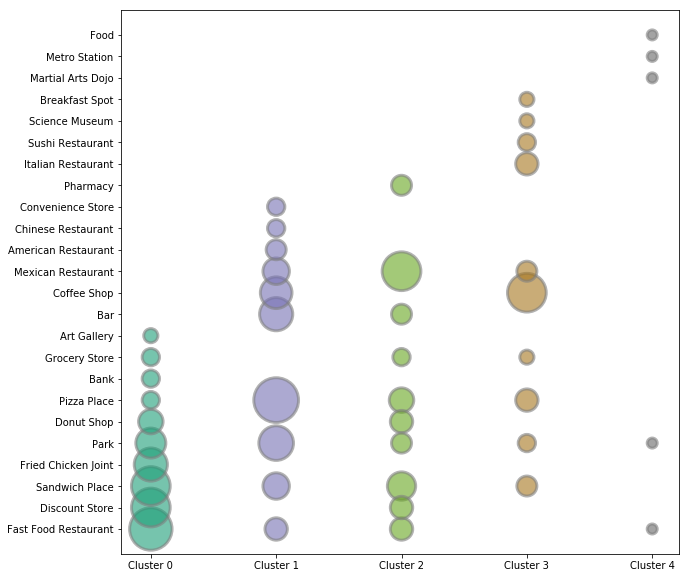

In [63]:
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111)
ax.scatter(x = clusters_counts['cluster_label'], y = clusters_counts['index'],
           s = clusters_counts['total']*100, c = clusters_counts['cluster_label'], 
           cmap = "Dark2", alpha = 0.6, edgecolors = "grey", linewidth = 3)


ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels(['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])

plt.savefig('2.6.png')

It is clear that fast food restaurants belong to cluster 0 and 2. Cluster 3 is apparently more well-doing, having the option to enjoy Italian restaurants and Sushi. 

### Obtain Resident Features Data

First, I find some variables to describe citizens in different neighborhoods. They come from various sources, so I have to do a little bit of data wrangling to get my desired dataframe. In total, I chose: 
1. per capita income
2. education status
3. employment status
4. age composition (in particular, % of residents who are under 18 or over 64)
5. ethnic/racial composition (which may lead to very different demand in venues, I guess)
6. people's choice of transportation

In [64]:
# Per Capita income and age data from the 2017 U.S. census data.
chi_census = pd.read_csv('censusData.csv')
chi_census.head()

,Community Area Number,COMMUNITY AREA NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX,NORM POP,NORM INCCAP
0,1,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39,0.544919,0.195581
1,2,West Ridge,7.8,17.2,8.8,20.8,38.5,23040,46,0.722161,0.184409
2,3,Uptown,3.8,24.0,8.9,11.8,22.2,35787,20,0.559255,0.342820
3,4,Lincoln Square,3.4,10.9,8.2,13.4,25.5,37524,17,0.382871,0.364406
4,5,North Center,0.3,7.5,5.2,4.5,26.2,57123,6,0.303133,0.607968


In [65]:
chi_census = chi_census[["COMMUNITY AREA NAME", "PER CAPITA INCOME ", "PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA", "PERCENT AGED 16+ UNEMPLOYED", "PERCENT AGED UNDER 18 OR OVER 64"]]
chi_census.rename(columns = {"COMMUNITY AREA NAME":"GEOG"}, inplace = True)

# Make amendments on false spellings
chi_census.GEOG[chi_census.GEOG == 'Montclaire'] = 'Montclare'
chi_census.GEOG[chi_census.GEOG == 'Washington Height'] = 'Washington Heights'
chi_census.GEOG[chi_census.GEOG == 'Loop'] = 'The Loop'
chi_census.GEOG[chi_census.GEOG == 'Humboldt park'] = 'Humboldt Park'
chi_census.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

,GEOG,PER CAPITA INCOME,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED UNDER 18 OR OVER 64
0,Rogers Park,23939,18.2,8.7,27.5
1,West Ridge,23040,20.8,8.8,38.5
2,Uptown,35787,11.8,8.9,22.2
3,Lincoln Square,37524,13.4,8.2,25.5
4,North Center,57123,4.5,5.2,26.2


In [66]:
# Other data from CMap Data Hub
chi_raw = pd.read_csv('ReferenceCCAProfiles20132017.csv')

In [67]:
# Race/ethnicity composition data
chi_eth = chi_raw[['GEOG', 'TOT_POP', 'WHITE', 'HISP', 'BLACK', 'ASIAN', 'OTHER']]

# Transform #people to percentage 
for col in chi_eth.columns[2:]: 
    chi_eth[col] = round(chi_eth[col]/chi_eth['TOT_POP'], 2)

chi = pd.merge(chi_eth, chi_census, how = 'outer', on = 'GEOG')
chi.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,GEOG,TOT_POP,WHITE,HISP,BLACK,ASIAN,OTHER,PER CAPITA INCOME,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED UNDER 18 OR OVER 64
0,Albany Park,51992,0.30,0.48,0.05,0.14,0.03,21323,32.9,10.0,32.0
1,Archer Heights,13142,0.17,0.77,0.01,0.04,0.00,16134,35.9,16.5,39.2
2,Armour Square,13455,0.13,0.04,0.09,0.73,0.01,16148,34.5,16.7,38.3
3,Ashburn,43792,0.11,0.39,0.48,0.01,0.02,23482,17.7,11.7,36.9
4,Auburn Gresham,46278,0.01,0.02,0.96,0.00,0.01,15528,18.5,28.3,41.9


In [68]:
chi.rename(columns = {'GEOG' : 'Community'}, inplace = True)
chi = chi.drop(['TOT_POP', 'OTHER'], axis = 1)
# Rename columns 
chi.rename(columns = {'WHITE':'%White', 
                      'HISP':'%Hisp',
                      'BLACK':'%Black',
                      'ASIAN':'%Asian',
                      'PER CAPITA INCOME ':'per_capita_income',
                      'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA': '%25+_no_diploma',
                      'PERCENT AGED 16+ UNEMPLOYED' : '%16+_unemployed',
                      'PERCENT AGED UNDER 18 OR OVER 64':'%under18_over64'}, inplace = True)
chi.head()

,Community,%White,%Hisp,%Black,%Asian,per_capita_income,%25+_no_diploma,%16+_unemployed,%under18_over64
0,Albany Park,0.30,0.48,0.05,0.14,21323,32.9,10.0,32.0
1,Archer Heights,0.17,0.77,0.01,0.04,16134,35.9,16.5,39.2
2,Armour Square,0.13,0.04,0.09,0.73,16148,34.5,16.7,38.3
3,Ashburn,0.11,0.39,0.48,0.01,23482,17.7,11.7,36.9
4,Auburn Gresham,0.01,0.02,0.96,0.00,15528,18.5,28.3,41.9


In [69]:
chi_cluster = chicago_merged[['Community', 'Cluster Labels']]
# Quick fix on Community Names
chi_cluster['Community'] = chi_cluster['Community'].str.split(', ').str.get(0)
chi_cluster.Community[chi_cluster.Community == 'Montclaire'] = 'Montclare'
chi_cluster.Community[chi_cluster.Community == 'Washington Height'] = 'Washington Heights'
chi_cluster.Community[chi_cluster.Community == 'Loop'] = 'The Loop'
chi_cluster.Community[chi_cluster.Community == 'Humboldt park'] = 'Humboldt Park'
chi_cluster.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-

,Community,Cluster Labels
0,Rogers Park,1
1,West Ridge,1
2,Uptown,3
3,Lincoln Square,1
4,North Center,1


In [33]:
chi_final = pd.merge(chi_cluster, chi, on = 'Community')
chi_final = chi_final.sort_values('Cluster Labels')

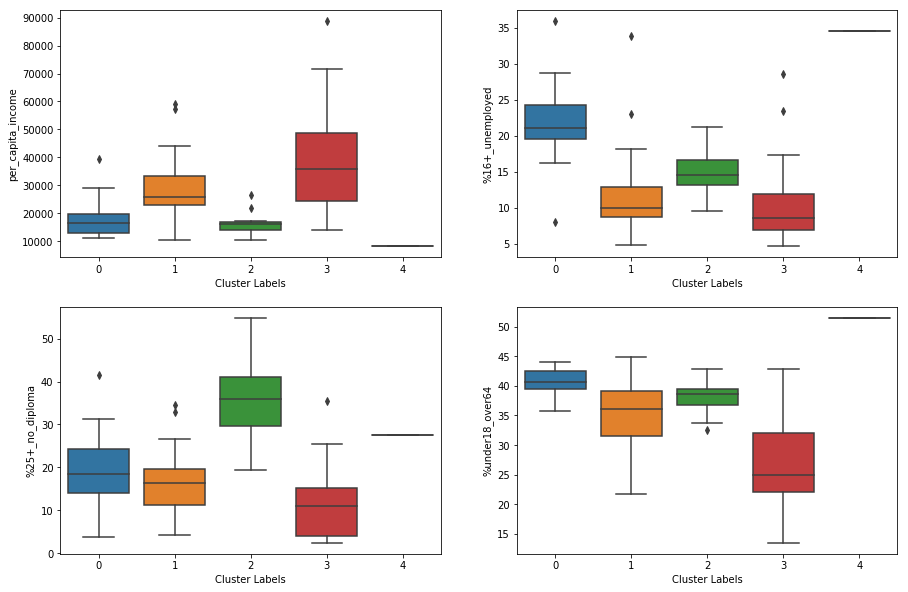

In [34]:
fig, axes = plt.subplots(2, 2, figsize = (15, 10))

sns.boxplot(x = 'Cluster Labels', y = 'per_capita_income', data = chi_final, ax = axes[0,0])
sns.boxplot(x = 'Cluster Labels', y = '%16+_unemployed', data = chi_final, ax = axes[0,1])
sns.boxplot(x = 'Cluster Labels', y = '%25+_no_diploma', data = chi_final, ax = axes[1,0])
sns.boxplot(x = 'Cluster Labels', y = '%under18_over64', data = chi_final, ax = axes[1,1])

plt.savefig('2.7.png')

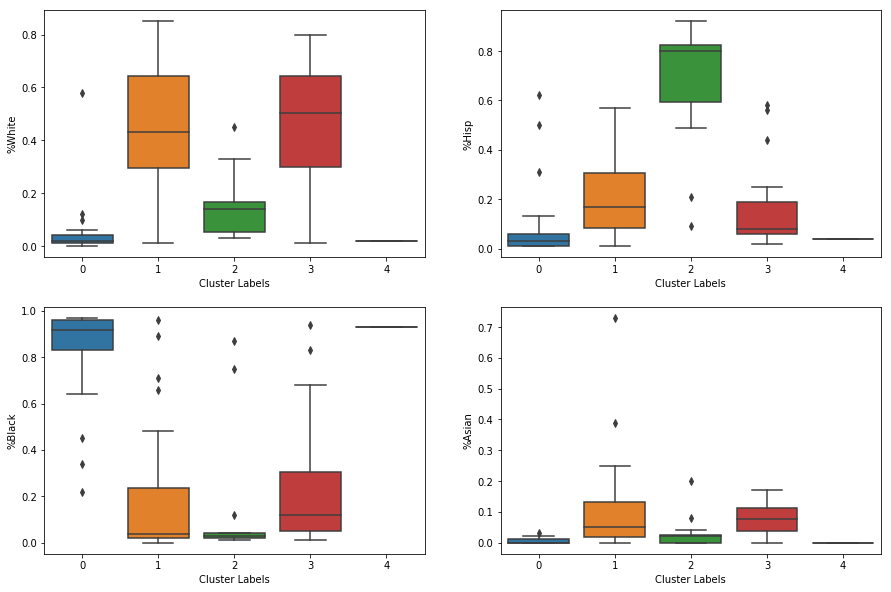

In [35]:
fig, axes = plt.subplots(2, 2, figsize = (15, 10))

sns.boxplot(x = 'Cluster Labels', y = '%White', data = chi_final, ax = axes[0,0])
sns.boxplot(x = 'Cluster Labels', y = '%Hisp', data = chi_final, ax = axes[0,1])
sns.boxplot(x = 'Cluster Labels', y = '%Black', data = chi_final, ax = axes[1,0])
sns.boxplot(x = 'Cluster Labels', y = '%Asian', data = chi_final, ax = axes[1,1])

plt.savefig('2.8.png')
plt.show()

In [36]:
# Import necessary packages
import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn import metrics

#!conda install -c conda-forge pydotplus -y
#!conda install -c conda-forge python-graphviz -y

from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

In [55]:
pd.DataFrame.to_csv(chi_final, 'chicagologtest.csv')

Now, we can see that ethnic compositions are pretty distinct among the four groups. Let's see if these features can really help us determine the clusters.

In [52]:
features = ['%White', '%Hisp', '%Black', '%Asian', 'per_capita_income', '%25+_no_diploma', '%16+_unemployed', '%under18_over64']
x = chi_final[features]
y = chi_final['Cluster Labels']

In [53]:
x = sm.add_constant(x)
x

,const,%White,%Hisp,%Black,%Asian,per_capita_income,%25+_no_diploma,%16+_unemployed,%under18_over64
42,1.0,0.03,0.01,0.94,0.01,19398,14.0,20.0,35.7
25,1.0,0.02,0.02,0.94,0.00,10934,24.5,25.8,43.6
24,1.0,0.05,0.13,0.81,0.01,15957,24.4,22.6,37.9
67,1.0,0.01,0.03,0.95,0.00,11888,28.5,28.0,42.5
65,1.0,0.04,0.50,0.45,0.00,13231,31.2,17.1,40.6
70,1.0,0.01,0.02,0.96,0.00,15528,18.5,28.3,41.9
35,1.0,0.03,0.05,0.90,0.02,19252,18.4,28.7,40.4
37,1.0,0.03,0.02,0.92,0.00,23472,15.9,24.3,39.5
26,1.0,0.06,0.04,0.89,0.01,12961,21.3,19.6,43.2
43,1.0,0.02,0.01,0.96,0.00,18881,14.5,24.0,40.3


In [57]:
import statsmodels.api as sm

logit_model = sm.MNLogit(y, x).fit()
logit_model.summary()

         Current function value: 0.561994
         Iterations: 35


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:         Cluster Labels   No. Observations:                   77
Model:                        MNLogit   Df Residuals:                       41
Method:                           MLE   Df Model:                           32
Date:                Sat, 17 Aug 2019   Pseudo R-squ.:                  0.6040
Time:                        11:42:53   Log-Likelihood:                -43.274
converged:                      False   LL-Null:                       -109.28
                                        LLR p-value:                 4.166e-14
=====================================================================================
 Cluster Labels=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                75.5586     65.971      1.145      0.252     -53.743     204.860
%White              -66.9461     65.890     -1.016      0.310    -196.088      62.195
%Hisp               -74.6018     65.187     -1.144      0.252    -202.366      53.162
%Black              -74.8109     65.824     -1.137      0.256    -203.823      54.201
%Asian              -35.6904     77.250     -0.462      0.644    -187.097     115.716
per_capita_income    -0.0001      0.000     -1.105      0.269      -0.000    9.81e-05
%25+_no_diploma      -0.0091      0.149     -0.061      0.952      -0.301       0.283
%16+_unemployed      -0.0865      0.159     -0.545      0.586      -0.398       0.225
%under18_over64       0.0038      0.229      0.017      0.987      -0.445       0.453
-------------------------------------------------------------------------------------
 Cluster Labels=2       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2961     89.483      0.003      0.997    -175.088     175.680
%White               -9.1284     92.975     -0.098      0.922    -191.357     173.100
%Hisp               -10.9261     91.190     -0.120      0.905    -189.655     167.803
%Black              -11.8628     92.281     -0.129      0.898    -192.730     169.005
%Asian               19.4063    100.063      0.194      0.846    -176.715     215.527
per_capita_income  1.939e-05      0.000      0.122      0.903      -0.000       0.000
%25+_no_diploma       0.2314      0.195      1.184      0.236      -0.152       0.614
%16+_unemployed      -0.2360      0.253     -0.932      0.351      -0.732       0.260
%under18_over64       0.1985      0.300      0.661      0.508      -0.390       0.787
-------------------------------------------------------------------------------------
 Cluster Labels=3       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               169.7944     76.228      2.227      0.026      20.391     319.198
%White             -155.8278     76.112     -2.047      0.041    -305.004      -6.652
%Hisp              -157.6310     74.173     -2.125      0.034    -303.008     -12.254
%Black             -159.4006     75.314     -2.116      0.034    -307.014     -11.787
%Asian             -142.2882     86.615     -1.643      0.100    -312.051      27.474
per_capita_income -9.548e-05      0.000     -0.852      0.394      -0.000       0.000
%25+_no_diploma      -0.0052      0.182     -0.029      0.977      -0.362       0.351
%16+_unemployed       0.0905      0.183      0.495      0.620      -0.268       0.449
%under18_over64      -0.3976      0.257     -1.547      0.122      -0.901       0.106
-------------------------------------------------------------------------------------
 Cluster Labels=4       coef    std err          z      P>|

In [59]:
margeff = logit_model.get_margeff()
margeff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
       MNLogit Marginal Effects      
=====================================
Dep. Variable:         Cluster Labels
Method:                          dydx
At:                           overall
=====================================================================================
 Cluster Labels=0      dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
%White                5.5619      4.388      1.267      0.205      -3.039      14.162
%Hisp                 5.9055      4.321      1.367      0.172      -2.563      14.374
%Black                5.9666      4.343      1.374      0.170      -2.546      14.479
%Asian                3.5950      5.482      0.656      0.512      -7.150      14.340
per_capita_income  5.922e-06   8.25e-06      0.718      0.473   -1.03e-05    2.21e-05
%25+_no_diploma      -0.0044      0.010     -0.438      0.662      -0.024       0.015
%16+_unemployed       0.0063      0.011      0.588      0.557      -0.015       0.027
%under18_over64       0.0033      0.017      0.202      0.840      -0.029       0.036
-------------------------------------------------------------------------------------
 Cluster Labels=1      dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
%White                0.6014      4.676      0.129      0.898      -8.563       9.766
%Hisp                -0.0972      4.478     -0.022      0.983      -8.874       8.680
%Black               -0.0106      4.583     -0.002      0.998      -8.993       8.971
%Asian                2.6425      4.870      0.543      0.587      -6.903      12.188
per_capita_income -9.533e-06   6.64e-06     -1.435      0.151   -2.26e-05    3.49e-06
%25+_no_diploma      -0.0063      0.013     -0.499      0.618      -0.031       0.018
%16+_unemployed      -0.0082      0.016     -0.514      0.607      -0.039       0.023
%under18_over64       0.0152      0.012      1.232      0.218      -0.009       0.039
-------------------------------------------------------------------------------------
 Cluster Labels=2      dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
%White                2.2550      4.297      0.525      0.600      -6.166      10.676
%Hisp                 2.3578      4.138      0.570      0.569      -5.752      10.468
%Black                2.3267      4.224      0.551      0.582      -5.952      10.606
%Asian                2.8974      4.298      0.674      0.500      -5.526      11.321
per_capita_income  4.742e-06   6.67e-06      0.712      0.477   -8.32e-06    1.78e-05
%25+_no_diploma       0.0123      0.009      1.349      0.177      -0.006       0.030
%16+_unemployed      -0.0109      0.013     -0.857      0.391      -0.036       0.014
%under18_over64       0.0131      0.012      1.093      0.274      -0.010       0.037
-------------------------------------------------------------------------------------
 Cluster Labels=3      dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
%White               -8.4183      3.965     -2.123      0.034     -16.190      -0.647
%Hisp                -8.1660      3.777     -2.162      0.031     -15.568      -0.764
%Black               -8.2826      3.861     -2.145      0.032     -15.850      -0.715
%Asian               -9.1350      4.087     -2.235      0.025     -17.146      -1.124
per_capita_income -1.132e-06   3.85e-06     -0.294      0.769   -8.69e-06    6.42e-06
%25+_no_diploma      -0.0016      0.011     -0.148      0.883      -0.023       0.020
%16+_unemployed       0.0128      0.013      0.981      0.327      -0.013       0.038
%under18_over64      -0.0316      0.010     -3.243      0.001   

In [39]:
# Split the dataset into 80% for training and 20% for testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=4)
print ('Train set:', x_train.shape[0],  y_train.shape[0])
print ('Test set:', x_test.shape[0],  y_test.shape[0])

Train set: 61 61
Test set: 16 16


In [40]:
# Make a decision tree object, then fit the model 
lr = LogisticRegression(multi_class='multinomial',solver ='newton-cg')

lr.fit(x_train, y_train) # fitting the data

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [41]:
# Predict the model, show accuracy score
yHat = lr.predict(x_test)
acc_score = metrics.accuracy_score(y_test, yHat)

acc_score

0.625

In [94]:
targetNames = np.unique(y_train).tolist()
targetNames = list(map(str, targetNames))
targetNames

['0', '1', '2', '3', '4']

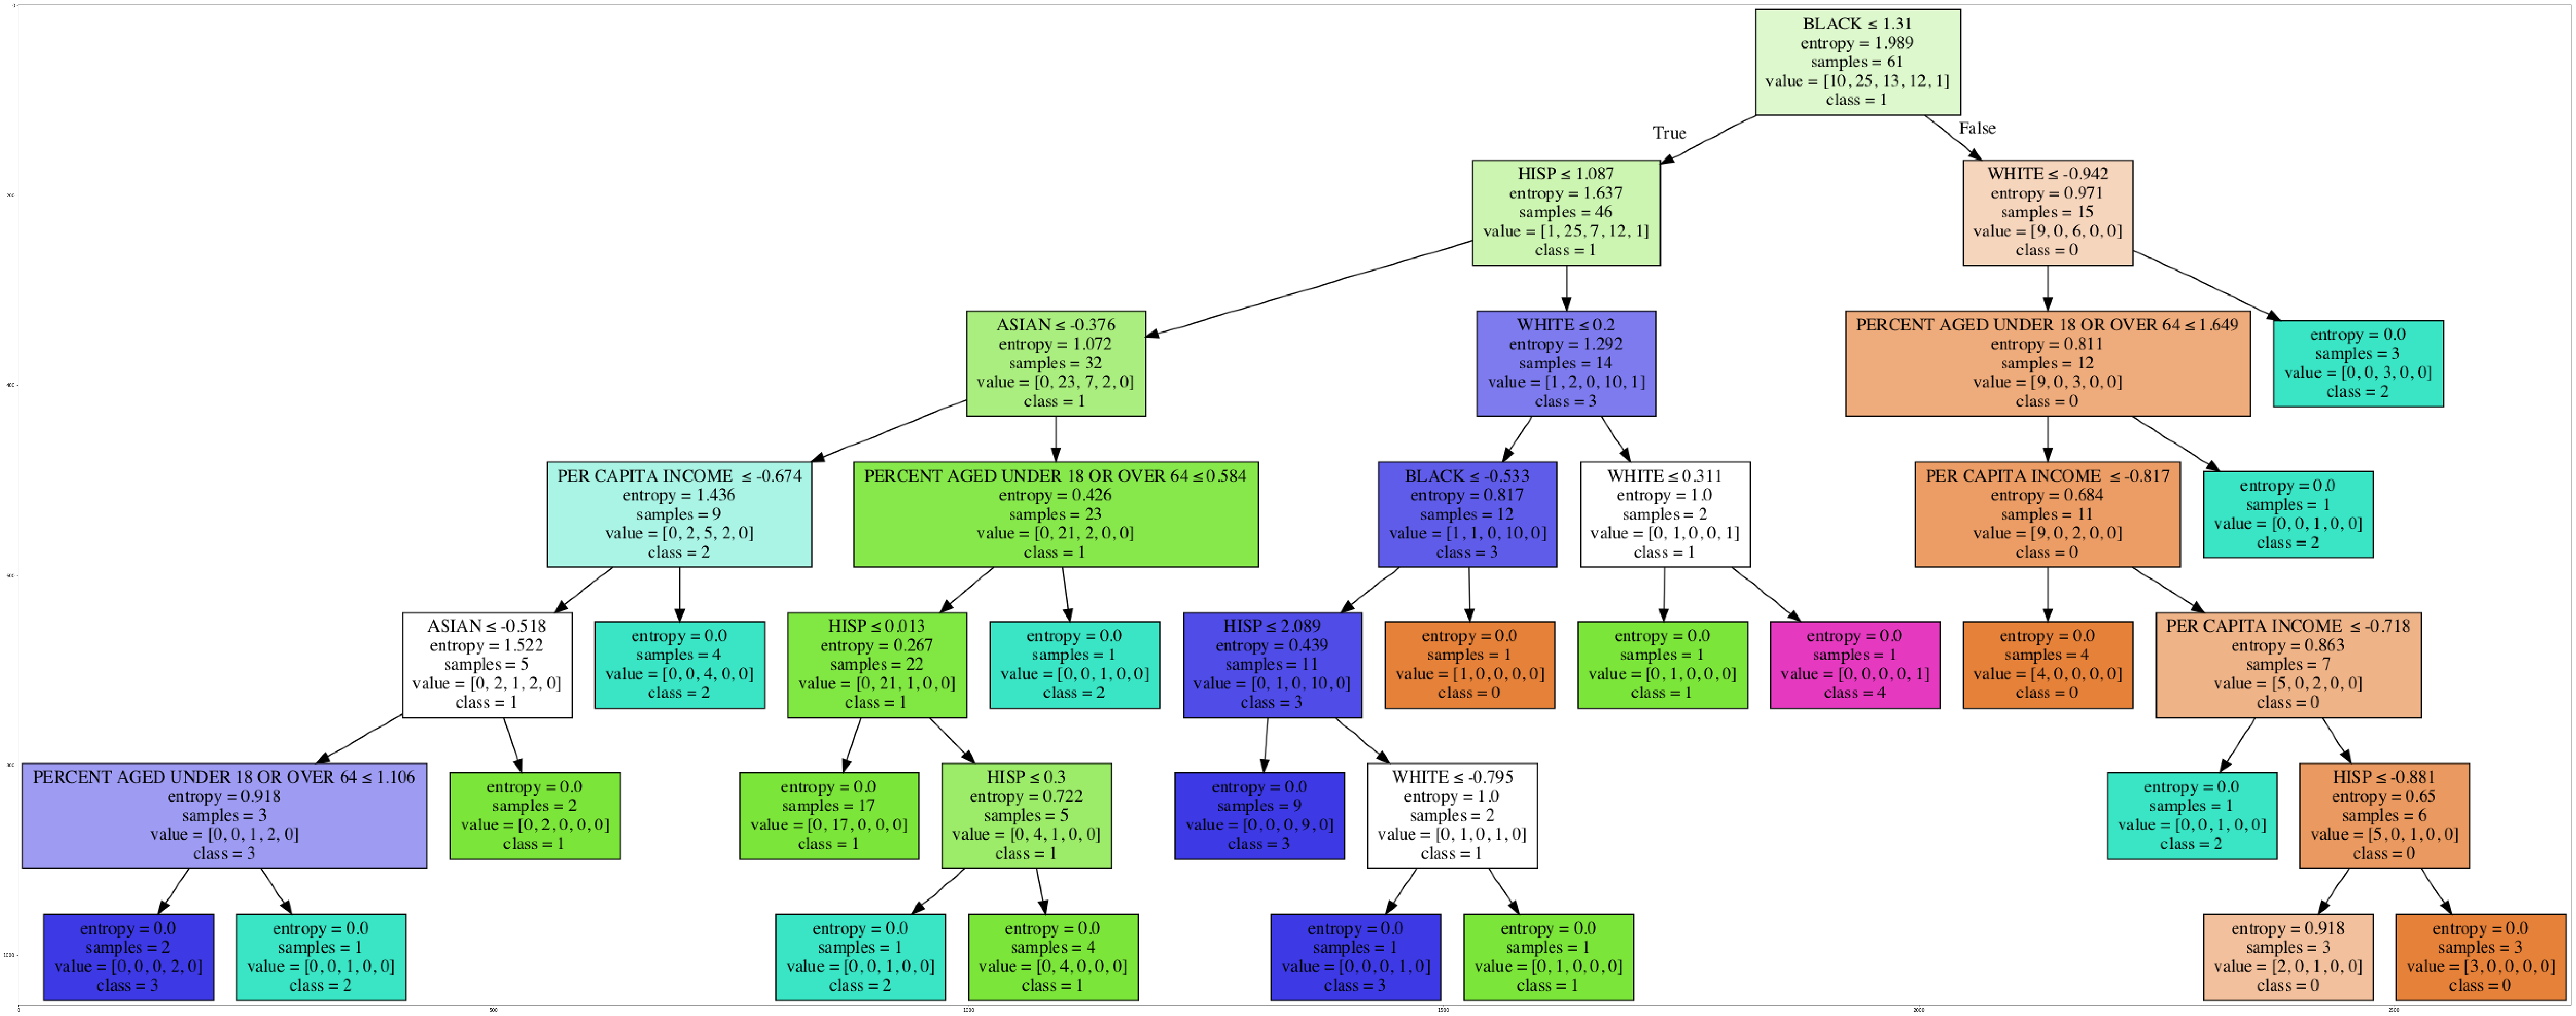

In [95]:
# Visualize
dot_data = StringIO()
filename = "loantree.png"
featureNames = features
targetNames = np.unique(y_train).tolist()
targetNames = list(map(str, targetNames))
targetNames
out = tree.export_graphviz(chiTree, feature_names = featureNames, 
                           out_file = dot_data, class_names = targetNames, 
                           filled = True, special_characters = True, rotate = False)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize = (100, 200))
plt.imshow(img, interpolation='nearest')

The decision tree model yields a 75% accuracy score, which is fairly high 